In [30]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

pd.set_option('display.max_columns',None)

In [31]:
# We take the oversampling dataset from Clustering
df = pd.read_csv('../Dataset/OverSampling.csv')
df.shape

(100000, 47)

In [32]:
df.head(2)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2169655,1,2020-06-12 12:56:58,2020-06-12 13:41:58,32.17783,-110.96829,32.17783,-110.96829,0.0,At S 12th Ave - Accident.,3798.0,S 6th Ave,R,Tucson,Pima,AZ,85713-6114,US,US/Mountain,KTUS,2020-06-12 12:58:00,100.0,100.0,12.0,27.23,10.0,WSW,9.0,0.0,Fair,False,False,True,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
1,A-2257101,1,2020-04-14 16:34:14,2020-04-14 17:19:14,33.63992,-112.11400,33.63992,-112.11400,0.0,At I-17/N Black Canyon Hwy - Accident.,NaN,N Black Canyon Hwy,R,Phoenix,Maricopa,AZ,85053,US,US/Mountain,KDVT,2020-04-14 16:53:00,76.0,76.0,15.0,28.36,10.0,WSW,10.0,0.0,Fair,False,False,True,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


In [33]:
df = df.drop(['ID','Description','End_Lat', 'End_Lng','Country', 'Pressure(in)','Weather_Condition','Number','Timezone','Zipcode','Airport_Code','Street'], axis=1)

df= df.rename(columns = {'Distance(mi)' : 'Distance_mi','Temperature(F)' : 'Temperature_F' ,'Wind_Chill(F)':'Wind_Chill_F',
                         'Humidity(%)' : 'Humidity_percentage' , 'Visibility(mi)': 'Visibility_mi',
                           'Wind_Speed(mph)': 'Wind_Speed_mph', 'Precipitation(in)': 'Precipitation_in' })
df.shape

(100000, 35)

<span style="font-size: 1.5em;">__Preprocessing__ </span>

In [34]:
df.columns

Index(['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'Distance_mi', 'Side', 'City', 'County', 'State', 'Weather_Timestamp',
       'Temperature_F', 'Wind_Chill_F', 'Humidity_percentage', 'Visibility_mi',
       'Wind_Direction', 'Wind_Speed_mph', 'Precipitation_in', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [35]:
# Create features from Start_Time and End_Time

df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['Start_Year'] = df['Start_Time'].dt.year
nmonth = df['Start_Time'].dt.month
df['Start_Month'] = nmonth
df['Start_Weekday']= df['Start_Time'].dt.weekday
days_each_month = np.cumsum(np.array([0,31,28,31,30,31,30,31,31,30,31,30,31]))
nday = [days_each_month[arg-1] for arg in nmonth.values]
nday = nday + df["Start_Time"].dt.day.values
df['Start_Day'] = nday
df['Start_Hour'] = df['Start_Time'].dt.hour
df['Start_Minute']=df['Start_Hour']*60.0+df["Start_Time"].dt.minute


df['End_Time'] = pd.to_datetime(df['End_Time'])
df['End_Year'] = df['End_Time'].dt.year
month = df['End_Time'].dt.month
df['End_Month'] = month
df['End_Weekday']= df['End_Time'].dt.weekday
days_each_month = np.cumsum(np.array([0,31,28,31,30,31,30,31,31,30,31,30,31]))
day = [days_each_month[arg-1] for arg in month.values]
day = day + df["End_Time"].dt.day.values
df['End_Day'] = day
df['End_Hour'] = df['End_Time'].dt.hour
df['End_Minute']=df['End_Hour']*60.0+df["End_Time"].dt.minute

df['Duration'] = round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))

df[['Duration','Start_Year','Start_Month','Start_Weekday','Start_Day','Start_Hour','Start_Minute',
    'End_Year','End_Month','End_Weekday','End_Day','End_Hour','End_Minute']].head()

,Duration,Start_Year,Start_Month,Start_Weekday,Start_Day,Start_Hour,Start_Minute,End_Year,End_Month,End_Weekday,End_Day,End_Hour,End_Minute
0,45.0,2020,6,4,163,12,776.0,2020,6,4,163,13,821.0
1,45.0,2020,4,1,104,16,994.0,2020,4,1,104,17,1039.0
2,45.0,2020,5,0,138,7,460.0,2020,5,0,138,8,505.0
3,65.0,2020,4,5,101,13,824.0,2020,4,5,101,14,889.0
4,65.0,2020,5,4,128,14,859.0,2020,5,4,128,15,924.0


In [36]:
# Create features from Weather_Timestamp

df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'])
df['date_of_Weather_Timestamp'] = df.Weather_Timestamp.dt.date
df['Weather_Timestamp_Year'] = df.Weather_Timestamp.dt.year
df['Weather_Timestamp_Month'] = df.Weather_Timestamp.dt.month
df['Weather_Timestamp_Day'] = df.Weather_Timestamp.dt.day
df['Weather_Timestamp_Weekday'] = df.Weather_Timestamp.dt.dayofweek
df['Weather_Timestamp_Hour'] = df.Weather_Timestamp.dt.hour

df[['date_of_Weather_Timestamp','Weather_Timestamp_Year','Weather_Timestamp_Month','Weather_Timestamp_Day',
    'Weather_Timestamp_Weekday','Weather_Timestamp_Hour']].head()

,date_of_Weather_Timestamp,Weather_Timestamp_Year,Weather_Timestamp_Month,Weather_Timestamp_Day,Weather_Timestamp_Weekday,Weather_Timestamp_Hour
0,2020-06-12,2020.0,6.0,12.0,4.0,12.0
1,2020-04-14,2020.0,4.0,14.0,1.0,16.0
2,2020-05-18,2020.0,5.0,18.0,0.0,7.0
3,2020-04-11,2020.0,4.0,11.0,5.0,13.0
4,2020-05-08,2020.0,5.0,8.0,4.0,13.0


In [37]:
# We dont need Start_Time, End_Time, Weather_Timestamp and date_of_Weather_Timestamp so we drop them
df = df.drop(['Start_Time'] , axis=1)
df = df.drop(['End_Time'] , axis=1)
df.drop(['Weather_Timestamp','date_of_Weather_Timestamp'],axis=1,inplace=True)
df.shape

(100000, 50)

**We prepare the numeric colums**

In [38]:
# Define the function to identify numeric columns with null values
def numeric_columns_with_nulls(df):
    count = 0
    for column in df:
        if df[column].dtype in ['float64', 'float32', 'int64']:
            if df[column].isna().sum() > 0:
                print(f'{column}: {df[column].isna().sum()}')
                count += 1
    if count == 0:
        print('No exist any Numeric columns with Nan Values')

numeric_columns_with_nulls(df)

Temperature_F: 2131
Wind_Chill_F: 25801
Humidity_percentage: 2251
Visibility_mi: 2350
Wind_Speed_mph: 7665
Precipitation_in: 30995
Weather_Timestamp_Year: 1458
Weather_Timestamp_Month: 1458
Weather_Timestamp_Day: 1458
Weather_Timestamp_Weekday: 1458
Weather_Timestamp_Hour: 1458


In [39]:
# HANDLING MISSING VALUES

# Specify the group columns and columns to fill with median values
group_columns = ['City']
columns_to_fill = ['Temperature_F', 'Wind_Chill_F', 'Humidity_percentage', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']

# Define the function to fill NaN values with medians
def fill_nan_values_with_median(df, group_columns, columns_to_fill):
    
    for column in columns_to_fill:
        # Calculate the median values per group
        median_values = df.groupby(group_columns)[column].transform('median')
        # Fill NaN values in the original DataFrame with the median values
        df[column].fillna(median_values, inplace=True)

    return df

df = fill_nan_values_with_median(df, group_columns, columns_to_fill)

numeric_columns_with_nulls(df)

# Drop the City column from the DataFrame
df.drop(["City"], axis=1, inplace=True)

Temperature_F: 206
Wind_Chill_F: 1598
Humidity_percentage: 214
Visibility_mi: 472
Wind_Speed_mph: 645
Precipitation_in: 2956
Weather_Timestamp_Year: 1458
Weather_Timestamp_Month: 1458
Weather_Timestamp_Day: 1458
Weather_Timestamp_Weekday: 1458
Weather_Timestamp_Hour: 1458


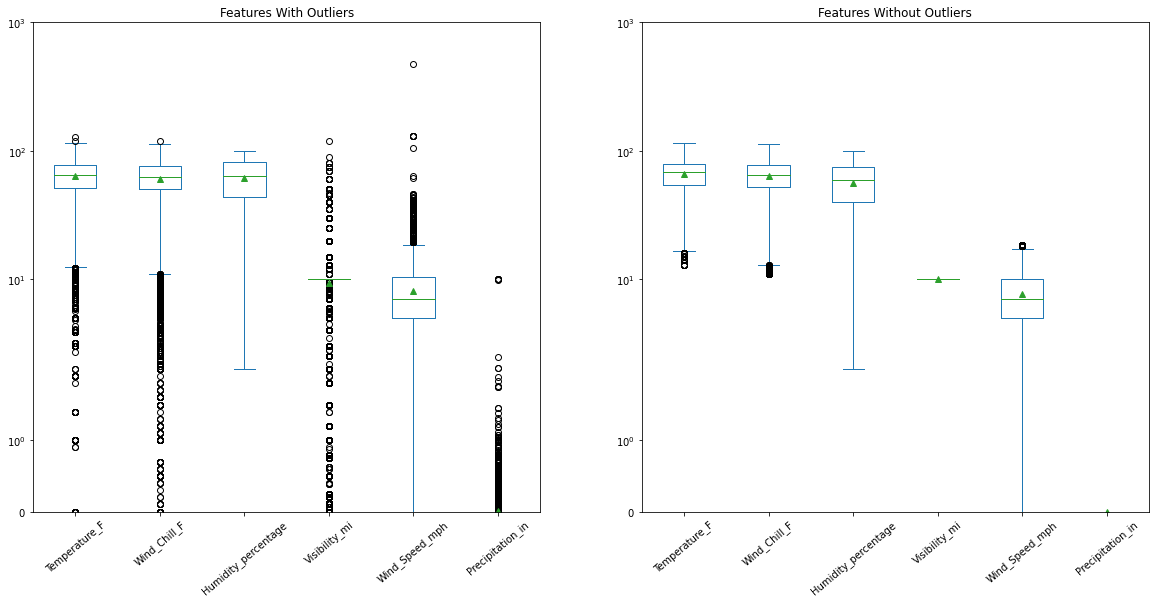

In [40]:
# DEALING WITH OUTLIERS

# Specify the features to check for outliers
features = ['Temperature_F', 'Wind_Chill_F', 'Humidity_percentage', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']

# Create the first plot with outliers
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
df[features].plot.box(ax=ax[0], rot=40, showmeans=True)
ax[0].set_title('Features With Outliers')  # Set the title for the first plot
ax[0].set_ylim(0, 1000)
ax[0].set_yscale('symlog')

# Drop the outliers using the IQR method
def remove_outliers_IQR_method(df, features):
    index_list = []

    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_indexes = df.index[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
        index_list.extend(outliers_indexes)

    df = df.drop(index_list)

    return df

df = remove_outliers_IQR_method(df, features)

# Create the second plot without outliers
df[features].plot.box(ax=ax[1], rot=40, showmeans=True)
ax[1].set_title('Features Without Outliers')  # Set the title for the second plot
ax[1].set_ylim(0, 1000)
ax[1].set_yscale('symlog')

plt.show()

In [41]:
# Create a list of columns to consider for dropping rows
subset_columns = columns_to_fill + ['Weather_Timestamp_Year', 'Weather_Timestamp_Month', 'Weather_Timestamp_Day',
                                    'Weather_Timestamp_Weekday', 'Weather_Timestamp_Hour']

# Drop rows with missing values (NaN)
df.dropna(subset=subset_columns, inplace=True)

numeric_columns_with_nulls(df)

No exist any Numeric columns with Nan Values


**We prepare the object columns**

In [42]:
# Define the function to print unique values in object-type columns
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}') 

print_unique_col_values(df)

Side: ['R' 'L']
County: ['Pima' 'Maricopa' 'El Paso' ... 'Buena Vista' 'Huntington' 'Tallapoosa']
State: ['AZ' 'TX' 'CA' 'NY' 'CO' 'OR' 'FL' 'TN' 'NC' 'WA' 'LA' 'VA' 'IL' 'WI'
 'MA' 'OH' 'MD' 'UT' 'SC' 'AL' 'GA' 'PA' 'DE' 'IN' 'NM' 'RI' 'OK' 'NJ'
 'DC' 'NE' 'MO' 'MN' 'KY' 'AR' 'KS' 'MI' 'MS' 'IA' 'CT' 'MT' 'ID' 'NV'
 'ND' 'ME' 'WV' 'NH' 'WY' 'SD' 'VT']
Wind_Direction: ['WSW' 'CALM' 'SW' 'W' 'VAR' 'S' 'NW' 'SSW' 'WNW' 'NNE' 'E' 'N' 'SSE' 'SE'
 'ESE' 'NNW' nan 'ENE' 'NE' 'North' 'Calm' 'Variable' 'West' 'South'
 'East']
Sunrise_Sunset: ['Day' 'Night' nan]
Civil_Twilight: ['Day' 'Night' nan]
Nautical_Twilight: ['Day' 'Night' nan]
Astronomical_Twilight: ['Day' 'Night' nan]


In [43]:
# Drop the nan values from specific columns
df.dropna(subset=['Wind_Direction','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'], inplace=True)

# Categorize the types of winds a little more briefly
df.loc[df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
df.loc[(df['Wind_Direction']=='West')|(df['Wind_Direction']=='WSW')|(df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
df.loc[(df['Wind_Direction']=='South')|(df['Wind_Direction']=='SSW')|(df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
df.loc[(df['Wind_Direction']=='North')|(df['Wind_Direction']=='NNW')|(df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
df.loc[(df['Wind_Direction']=='East')|(df['Wind_Direction']=='ESE')|(df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
df.loc[df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'

# Encode
# Create to booleans with 0 and 1 the specific columns
df = df.replace([True, False], [1,0])
df = df.replace(["Day","Night"],[1,0])
df = df.replace(["R","L"],[1,0])

# We keep that for the second model
df2 = df.copy()
df2.drop(["County",'State'], axis=1, inplace=True)

print_unique_col_values(df)

County: ['Pima' 'Maricopa' 'El Paso' ... 'Buena Vista' 'Huntington' 'Tallapoosa']
State: ['AZ' 'TX' 'CA' 'NY' 'CO' 'OR' 'FL' 'TN' 'NC' 'WA' 'LA' 'VA' 'IL' 'WI'
 'MA' 'OH' 'MD' 'UT' 'SC' 'AL' 'GA' 'PA' 'DE' 'IN' 'NM' 'RI' 'OK' 'NJ'
 'DC' 'NE' 'MO' 'MN' 'KY' 'AR' 'KS' 'MI' 'MS' 'IA' 'CT' 'MT' 'ID' 'NV'
 'ND' 'ME' 'WV' 'NH' 'WY' 'SD' 'VT']
Wind_Direction: ['W' 'CALM' 'SW' 'VAR' 'S' 'NW' 'N' 'E' 'SE' 'NE']


In [44]:
max(df.isna().sum())

0

In [45]:
# One-Hot Encode
# Specify the columns containing categorical/object values
object_values = ["State", "Wind_Direction", "County"]

# Convert the specified columns to categorical data type
df[object_values] = df[object_values].astype('category')
df2['Wind_Direction'] = df2['Wind_Direction'].astype('category')

# Perform one-hot encoding on the categorical columns
df = pd.get_dummies(df, columns=object_values, drop_first=True)
df2 = pd.get_dummies(df2, columns=["Wind_Direction"], drop_first=True)

In [46]:
df.shape

(72703, 1279)

In [47]:
df.head(3)

,Severity,Start_Lat,Start_Lng,Distance_mi,Side,Temperature_F,Wind_Chill_F,Humidity_percentage,Visibility_mi,Wind_Speed_mph,Precipitation_in,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Start_Year,Start_Month,Start_Weekday,Start_Day,Start_Hour,Start_Minute,End_Year,End_Month,End_Weekday,End_Day,End_Hour,End_Minute,Duration,Weather_Timestamp_Year,Weather_Timestamp_Month,Weather_Timestamp_Day,Weather_Timestamp_Weekday,Weather_Timestamp_Hour,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Wind_Direction_E,Wind_Direction_N,Wind_Direction_NE,Wind_Direction_NW,Wind_Direction_S,Wind_Direction_SE,Wind_Direction_SW,Wind_Direction_VAR,Wind_Direction_W,County_Acadia,County_Accomack,County_Ada,County_Adair,County_Adams,County_Addison,County_Aiken,County_Aitkin,County_Alachua,County_Alamance,County_Alameda,County_Albany,County_Albemarle,County_Alexander,County_Alexandria,County_Alexandria City,County_Allamakee,County_Allegan,County_Allegany,County_Alleghany,County_Allegheny,County_Allen,County_Alpena,County_Alpine,County_Amador,County_Amelia,County_Amherst,County_Anderson,County_Andrews,County_Anne Arundel,County_Anoka,County_Apache,County_Appanoose,County_Appomattox,County_Arapahoe,County_Arenac,County_Arkansas,County_Arlington,County_Armstrong,County_Ascension,County_Ashe,County_Ashland,County_Ashley,County_Ashtabula,County_Atascosa,County_Atkinson,County_Atlantic,County_Augusta,County_Autauga,County_Avery,County_Baca,County_Baker,County_Baldwin,County_Baltimore,County_Baltimore City,County_Baltimore County,County_Bamberg,County_Bannock,County_Barnstable,County_Barnwell,County_Barren,County_Barron,County_Barrow,County_Barry,County_Bartholomew,County_Bartow,County_Bastrop,County_Bath,County_Bay,County_Beadle,County_Bear Lake,County_Beaufort,County_Beaver,County_Beaverhead,County_Becker,County_Bedford,County_Bedford County,County_Bell,County_Belmont,County_Beltrami,County_Benewah,County_Bent,County_Benton,County_Benzie,County_Bergen,County_Berkeley,County_Berks,County_Berkshire,County_Bernalillo,County_Berrien,County_Bertie,County_Bexar,County_Bibb,County_Bienville,County_Big Horn,County_Billings,County_Bingham,County_Black Hawk,County_Bladen,County_Blair,County_Bland,County_Bledsoe,County_Blount,County_Blue Earth,County_Boise,County_Bonner,County_Bonneville,County_Boone,County_Bossier,County_Botetourt,County_Boulder,County_Boundary,County_Bowie,County_Box Elder,County_Bradford,County_Bradley,County_Branch,County_Braxton,County_Brazoria,County_Bremer,County_Brevard,County_Bristol,County_Bronx,County_Brooks,County_Broome,County_Broomfield,County_Broward,County_Brown,County_Brunswick,County_Bryan,County_Buchanan,County_Buckingham,County_Bucks,County_Buena Vista,County_Buffalo,County_Bullitt,County_Bulloch,County_Buncombe,County_Bureau,County_Burke,County_Burleigh,County_Burlington,County_Burnett,County_Burt,County_Butler,County_Butte,County_Butts,County_Cabarrus,County_Cabell,County_Cache,County_Caddo,County_Calaveras,County_Calcasieu,County_Caldwell,County_Calhoun,County_Callaway,County_Calvert,County_Cambria,County_Camden,County_Cameron,County_Campbell,County_Canadian,County_Cannon,County_Canyon,County_Cape May,County_Carbon,County_Carlton,County_Caroline,County_Carroll,County_Carson City,County_Carter,County_Carteret,County_Carver,County_Cascade,County_Cass,County_Cassia,County_Caswell,County_Catawba,County_Catoosa,County_Cattaraugus,County_Cayuga,County_Cecil,County_Cedar,County_Centre,County_Cerro Gordo,County_Chaf

In [48]:
#----------------------
# Scaled in 0 and 1 with MinMaxScaler.
#----------------------

# Identify the numeric columns and the target
numeric_columns = df.select_dtypes(include=['float64', 'float32', 'int64']).columns
# Specify the target column
target = 'Severity'

# Exclude the columns that contain only 0 and 1 and it is not the target column
columns_to_scale = [col for col in numeric_columns if ((set(df[col].unique()) != {0, 1}) and (col != target))]

# Print the columns to be scaled
print(columns_to_scale)

# Scale the columns in the range of 0 and 1 using MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to the selected columns in the DataFrame
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

['Start_Lat', 'Start_Lng', 'Distance_mi', 'Temperature_F', 'Wind_Chill_F', 'Humidity_percentage', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in', 'Turning_Loop', 'Start_Year', 'Start_Month', 'Start_Weekday', 'Start_Day', 'Start_Hour', 'Start_Minute', 'End_Year', 'End_Month', 'End_Weekday', 'End_Day', 'End_Hour', 'End_Minute', 'Duration', 'Weather_Timestamp_Year', 'Weather_Timestamp_Month', 'Weather_Timestamp_Day', 'Weather_Timestamp_Weekday', 'Weather_Timestamp_Hour']


In [49]:
# Check if we have in df a not scaled column
for col in df:
    if (df[col].max() > 1 or df[col].min() < 0) and col != target:
        print(col)

Start_Lat
Start_Lng


In [50]:
min(df.Start_Lat), min(df.Start_Lng)

(0.0, 0.0)

In [51]:
max(df.Start_Lat), max(df.Start_Lng)

(1.0000000000000002, 1.0000000000000002)

In [52]:
# Create X and y for the training
X= df.drop(["Severity"],axis = 1)
y = df['Severity']
X.to_numpy().astype('float')

array([[0.31183291, 0.23679871, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.37177143, 0.21663314, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.29501713, 0.3159112 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.66177773, 0.22032758, 0.00375678, ..., 0.        , 0.        ,
        0.        ],
       [0.58051204, 0.82504532, 0.00166896, ..., 0.        , 0.        ,
        0.        ],
       [0.56187964, 0.67968038, 0.00196538, ..., 0.        , 0.        ,
        0.        ]])

In [53]:
# Split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
print(f'The split of data is this\n\nFor the train data:\n  X_train {X_train.shape}\n  y_train is {y_train.shape}\n\n'+
      f'For the test data:\n  X_test {X_test.shape}\n  y_test is {y_test.shape}')


The split of data is this

For the train data:
  X_train (58162, 1278)
  y_train is (58162,)

For the test data:
  X_test (14541, 1278)
  y_test is (14541,)


**Model1**

In [75]:
# Create the model.
model = keras.Sequential([
    keras.layers.Input(shape=(X.shape[1],)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.4,),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2,),
    keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=15,epochs=50,verbose=1,validation_split=0.2, callbacks=[earlyStopping])

Epoch 1/50
3102/3102 [==============================] - 26s 8ms/step - loss: 0.8045 - accuracy: 0.6728 - val_loss: 0.6629 - val_accuracy: 0.7309
Epoch 2/50
3102/3102 [==============================] - 23s 7ms/step - loss: 0.6671 - accuracy: 0.7321 - val_loss: 0.6475 - val_accuracy: 0.7379
Epoch 3/50
3102/3102 [==============================] - 23s 7ms/step - loss: 0.6315 - accuracy: 0.7476 - val_loss: 0.6203 - val_accuracy: 0.7448
Epoch 4/50
3102/3102 [==============================] - 22s 7ms/step - loss: 0.6111 - accuracy: 0.7561 - val_loss: 0.6250 - val_accuracy: 0.7406
Epoch 5/50
3102/3102 [==============================] - 24s 8ms/step - loss: 0.5977 - accuracy: 0.7612 - val_loss: 0.6126 - val_accuracy: 0.7505
Epoch 6/50
3102/3102 [==============================] - 21s 7ms/step - loss: 0.5836 - accuracy: 0.7680 - val_loss: 0.6080 - val_accuracy: 0.7517
Epoch 7/50
3102/3102 [==============================] - 22s 7ms/step - loss: 0.5748 - accuracy: 0.7711 - val_loss: 0.6083 - val_ac

**Model2**

In [76]:
df2.head()

,Severity,Start_Lat,Start_Lng,Distance_mi,Side,Temperature_F,Wind_Chill_F,Humidity_percentage,Visibility_mi,Wind_Speed_mph,Precipitation_in,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Start_Year,Start_Month,Start_Weekday,Start_Day,Start_Hour,Start_Minute,End_Year,End_Month,End_Weekday,End_Day,End_Hour,End_Minute,Duration,Weather_Timestamp_Year,Weather_Timestamp_Month,Weather_Timestamp_Day,Weather_Timestamp_Weekday,Weather_Timestamp_Hour,Wind_Direction_E,Wind_Direction_N,Wind_Direction_NE,Wind_Direction_NW,Wind_Direction_S,Wind_Direction_SE,Wind_Direction_SW,Wind_Direction_VAR,Wind_Direction_W
0,1,32.17783,-110.96829,0.0,1,100.0,100.0,12.0,10.0,9.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1,1,2020,6,4,163,12,776.0,2020,6,4,163,13,821.0,45.0,2020.0,6.0,12.0,4.0,12.0,0,0,0,0,0,0,0,0,1
1,1,33.63992,-112.11400,0.0,1,76.0,76.0,15.0,10.0,10.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1,1,2020,4,1,104,16,994.0,2020,4,1,104,17,1039.0,45.0,2020.0,4.0,14.0,1.0,16.0,0,0,0,0,0,0,0,0,1
2,1,31.76764,-106.47350,0.0,1,73.0,73.0,20.0,10.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2020,5,0,138,7,460.0,2020,5,0,138,8,505.0,45.0,2020.0,5.0,18.0,0.0,7.0,0,0,0,0,0,0,0,0,0
3,1,31.71112,-106.36806,0.0,1,72.0,72.0,11.0,10.0,17.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2020,4,5,101,13,824.0,2020,4,5,101,14,889.0,65.0,2020.0,4.0,11.0,5.0,13.0,0,0,0,0,0,0,1,0,0
4,1,33.48051,-112.01290,0.0,0,98.0,98.0,10.0,10.0,9.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1,1,2020,5,4,128,14,859.0,2020,5,4,128,15,924.0,65.0,2020.0,5.0,8.0,4.0,13.0,0,0,0,0,0,0,0,0,1


In [77]:
import warnings
warnings.filterwarnings("ignore")

X_model2= df2.drop(["Severity"],axis = 1)
X_model2 = X_model2.astype(np.float)
y_model2 = df2['Severity']
scaler = StandardScaler()
X_model2 = scaler.fit_transform(X_model2)
X_model2

array([[-0.82976414, -0.87994518, -0.33769449, ..., -0.24288335,
        -0.22690857,  2.05890764],
       [-0.54580488, -0.9456495 , -0.33769449, ..., -0.24288335,
        -0.22690857,  2.05890764],
       [-0.90942904, -0.6221774 , -0.33769449, ..., -0.24288335,
        -0.22690857, -0.48569444],
       ...,
       [ 0.82810242, -0.93361213, -0.03781   , ..., -0.24288335,
        -0.22690857, -0.48569444],
       [ 0.44310552,  1.03670568, -0.20446965, ..., -0.24288335,
        -0.22690857, -0.48569444],
       [ 0.35483439,  0.5630713 , -0.18080809, ..., -0.24288335,
        -0.22690857, -0.48569444]])

In [78]:
# Split the data to train and test
X_model2_train, X_model2_test, y_model2_train, y_model2_test = train_test_split(X_model2, y_model2, test_size=0.2, random_state=5)
print(f'The split of data is this\n\nFor the train data:\n  X_train {X_model2_train.shape}\n  y_train is {y_model2_train.shape}\n\n'+
      f'For the test data:\n  X_test {X_model2_test.shape}\n  y_test is {y_model2_test.shape}')

The split of data is this

For the train data:
  X_train (58162, 54)
  y_train is (58162,)

For the test data:
  X_test (14541, 54)
  y_test is (14541,)


In [79]:
# Create the model.
model2 = keras.Sequential([
    keras.layers.Input(shape=(X_model2.shape[1],)),
    keras.layers.Dense(124, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(5, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

earlyStopping2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history2 = model2.fit(X_model2_train, y_model2_train, batch_size=40,epochs=50,verbose=1,validation_split=0.2, callbacks=[earlyStopping2])

Epoch 1/50
1164/1164 [==============================] - 4s 3ms/step - loss: 0.8204 - accuracy: 0.6565 - val_loss: 0.7393 - val_accuracy: 0.6789
Epoch 2/50
1164/1164 [==============================] - 3s 2ms/step - loss: 0.7104 - accuracy: 0.6982 - val_loss: 0.6947 - val_accuracy: 0.7001
Epoch 3/50
1164/1164 [==============================] - 3s 3ms/step - loss: 0.6815 - accuracy: 0.7117 - val_loss: 0.6850 - val_accuracy: 0.7119
Epoch 4/50
1164/1164 [==============================] - 3s 2ms/step - loss: 0.6633 - accuracy: 0.7201 - val_loss: 0.6718 - val_accuracy: 0.7136
Epoch 5/50
1164/1164 [==============================] - 3s 2ms/step - loss: 0.6513 - accuracy: 0.7252 - val_loss: 0.6742 - val_accuracy: 0.7132
Epoch 6/50
1164/1164 [==============================] - 3s 3ms/step - loss: 0.6385 - accuracy: 0.7299 - val_loss: 0.6655 - val_accuracy: 0.7180
Epoch 7/50
1164/1164 [==============================] - 3s 3ms/step - loss: 0.6300 - accuracy: 0.7339 - val_loss: 0.6595 - val_accuracy:

**Evaluate the Models**

In [80]:
print('Test Loss of Model is ',  model.evaluate(X_test, y_test)[0] ,'  |  Test Accuracy is ', model.evaluate(X_test, y_test)[1],'\n\n')

print('Test Loss of Model2 is ', model2.evaluate(X_model2_test, y_model2_test)[0] ,'  |  Test Accuracy is ',model2.evaluate(X_model2_test, y_model2_test)[1])

455/455 [==============================] - 2s 4ms/step - loss: 0.5982 - accuracy: 0.7627
Test Loss of Model is  0.5981993675231934   |  Test Accuracy is  0.7626710534095764 


455/455 [==============================] - 1s 2ms/step - loss: 0.6490 - accuracy: 0.7286
Test Loss of Model2 is  0.6490176320075989   |  Test Accuracy is  0.7286294102668762


In [81]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1) #Predicted Class Value
print('\nFor Model:\n',y_pred,'\n\n')

Y_pred2 = model2.predict(X_model2_test)
y_pred2 = np.argmax(Y_pred2, axis=1) #Predicted Class Value
print('\nFor Model2:\n',y_pred2)

455/455 [==============================] - 2s 3ms/step

For Model:
 [3 1 2 ... 3 2 1] 


455/455 [==============================] - 1s 2ms/step

For Model2:
 [4 1 2 ... 3 2 1]


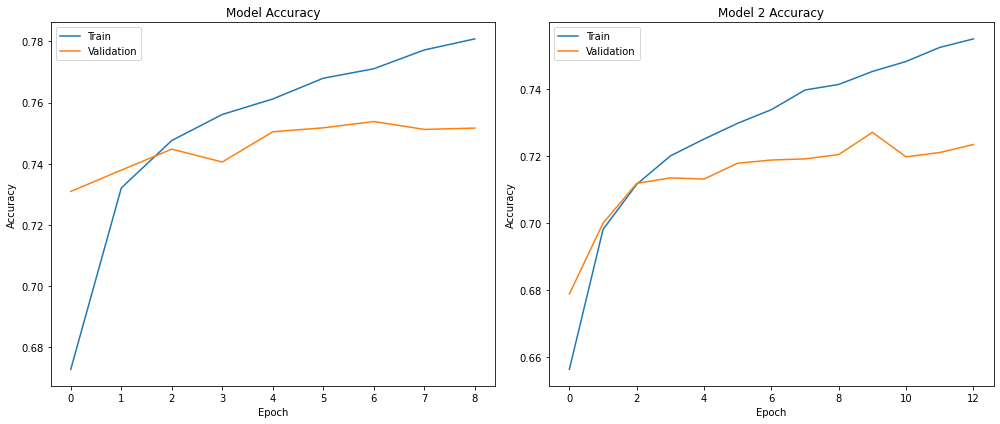

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# PLOT TRAINING AND VALIDATION ACCURACY VALUES | Model
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# PLOT TRAINING AND VALIDATION ACCURACY VALUES | Model2
axs[1].plot(history2.history['accuracy'])
axs[1].plot(history2.history['val_accuracy'])
axs[1].set_title('Model 2 Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


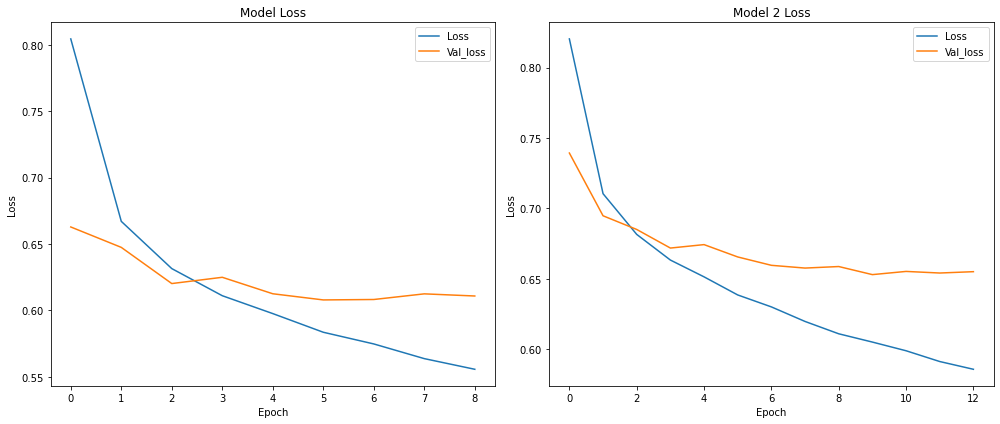

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

#PLOT TRAINING AND VALIDATION LOSS VALUES | Model
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Model Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(['Loss' , 'Val_loss'] , loc='upper right')

#PLOT TRAINING AND VALIDATION LOSS VALUES | Model2
axs[1].plot(history2.history['loss'])
axs[1].plot(history2.history['val_loss'])
axs[1].set_title('Model 2 Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Loss' , 'Val_loss'] , loc='upper right')

plt.tight_layout()
plt.show()


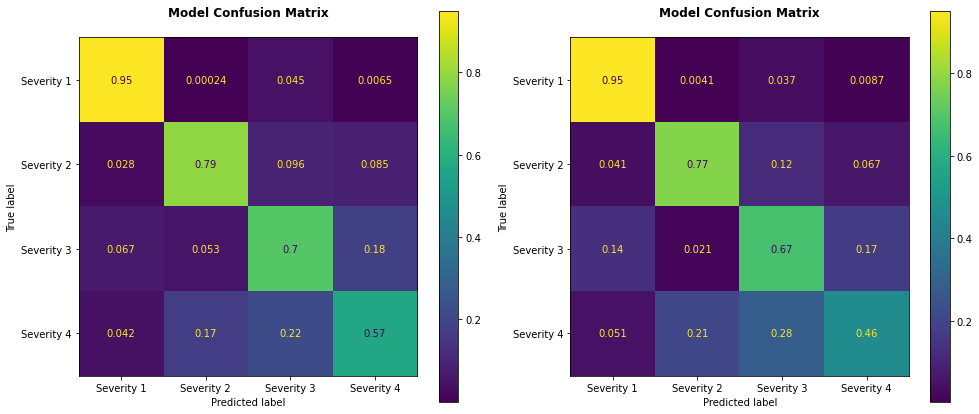

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# PLOT CONFUSION METRIX | Model
mat1 = metrics.confusion_matrix(y_test, y_pred, normalize='true')
cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix=mat1, display_labels=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'])
cm_display1.plot(ax=axs[0])
axs[0].set_title('Model Confusion Matrix\n',fontweight='bold')

# PLOT CONFUSION METRIX | Model2
mat1 = metrics.confusion_matrix(y_model2_test, y_pred2, normalize='true')
cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix=mat1, display_labels=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'])
cm_display1.plot(ax=axs[1])
axs[1].set_title('Model Confusion Matrix\n',fontweight='bold')

plt.tight_layout()
plt.show()